# Timelag Analysis: Varying the LOS Angle

In [1]:
import os
import sys

import numpy as np
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from astropy.coordinates import SkyCoord
from sunpy.map import Map
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../scripts/')
from timelags import AIATimeLags

%matplotlib inline

In [45]:
client = dask.distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/146729/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


In [95]:
client.close()

For one of our heating cases (likely intermediate-frequency heating), compute the timelags for a two (maybe three?) different lines of sight:
* as observed by AIA/HMI ("earth")
* rotated 90 degrees in longitude with respect to the surface normal at the center of the AR ("off-limb")
* if the AR was at disk center ("disk center")
* rotated 90 degrees in latitude with respect to the surface normal at the center of the AR ("arcade")

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')

First, we need to rebin the intensity values for our intermediate frequency case for the face-on, off-limb, arcade observers. We've already compute the case where the observer is just the SDO satellite (i.e. an observer at Earth). 

In [3]:
aia_earth = InstrumentSDOAIA([5000,25000]*u.s, observer_coordinate=field.magnetogram.observer_coordinate)
aia_earth.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/SDO_AIA_counts.h5'

### Off-limb

In [4]:
off_limb_observer_coordinate = SkyCoord(lat=field.magnetogram.observer_coordinate.lat,
                                        lon=field.magnetogram.center.transform_to('heliographic_stonyhurst').lon - 90 * u.deg,
                                        radius=field.magnetogram.observer_coordinate.radius,
                                        frame='heliographic_stonyhurst')

In [5]:
aia_off_limb = InstrumentSDOAIA([5000,25000] * u.s, observer_coordinate=off_limb_observer_coordinate)

In [6]:
observer = synthesizAR.Observer(field, [aia_off_limb], parallel=True)

In [7]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/', 0.5 * u.Mm)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [ ]:
bin_futures = observer.bin_detector_counts(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/off_limb/')

### Disk-center

In [8]:
center_hgs = field.magnetogram.center.transform_to('heliographic_stonyhurst')
disk_center_observer_coordinate = SkyCoord(lat=center_hgs.lat,
                                           lon=center_hgs.lon,
                                           radius=field.magnetogram.observer_coordinate.radius,
                                           frame='heliographic_stonyhurst')

In [9]:
aia_disk_center = InstrumentSDOAIA([5000,25000] * u.s,observer_coordinate=disk_center_observer_coordinate)

In [10]:
observer = synthesizAR.Observer(field, [aia_disk_center], parallel=True)

In [11]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/', 0.5 * u.Mm)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [ ]:
bin_futures = observer.bin_detector_counts(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/nei/disk_center/')

### Arcade

In [54]:
center_hgs = field.magnetogram.center.transform_to('heliographic_stonyhurst')
arcade_observer_coordinate = SkyCoord(lat=center_hgs.lat + 90 * u.deg,
                                      lon=center_hgs.lon,
                                      radius=field.magnetogram.observer_coordinate.radius,
                                      frame='heliographic_stonyhurst')

In [55]:
aia_arcade = InstrumentSDOAIA([5000,25000] * u.s, observer_coordinate=arcade_observer_coordinate)

In [56]:
observer = synthesizAR.Observer(field, [aia_arcade], parallel=True)

In [57]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/', 0.5 * u.Mm)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [ ]:
bin_futures = observer.bin_detector_counts(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/nei/arcade/')

## Peek Intensity Maps

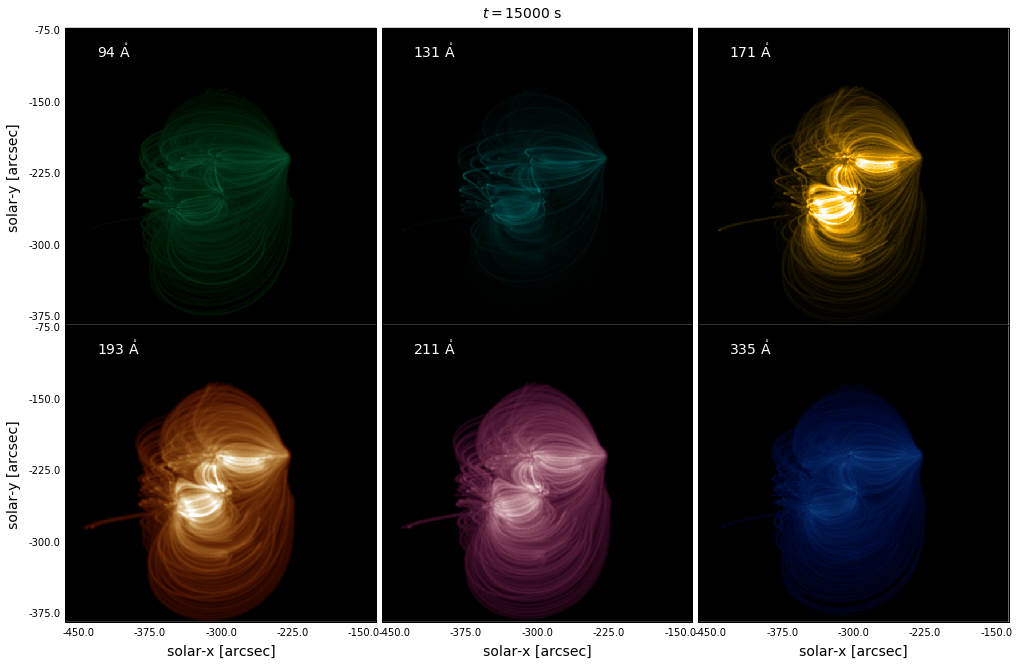

In [16]:
plot_aia_channels(aia_earth, 15000 * u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()),
                  figsize=(17,10))

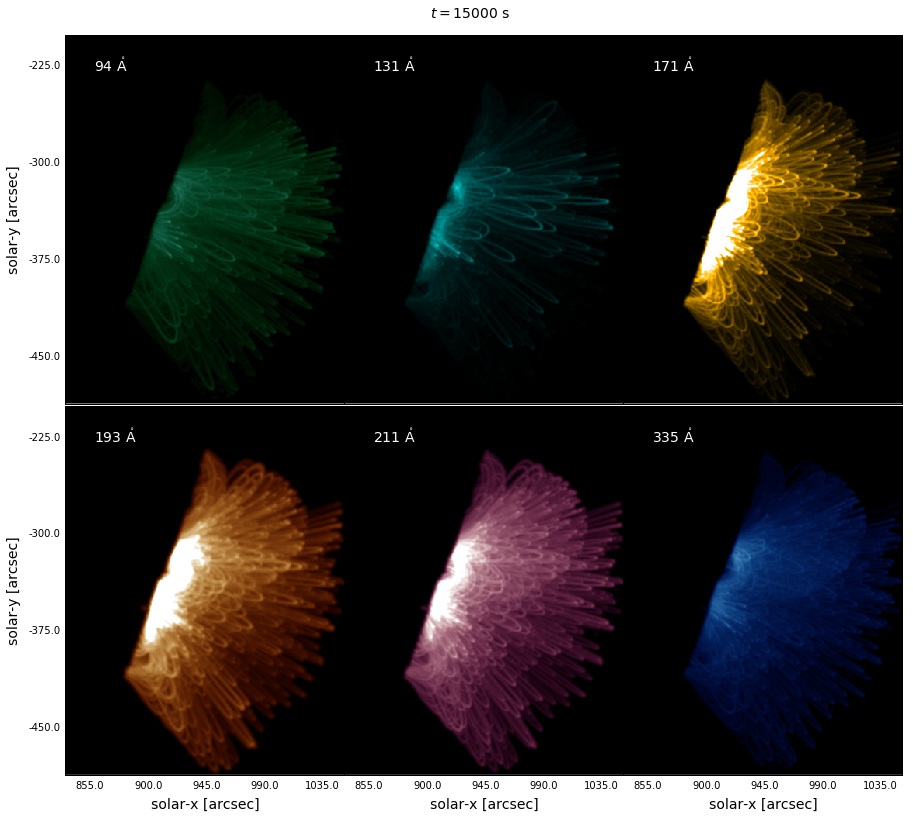

In [17]:
plot_aia_channels(aia_off_limb, 15000 * u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/off_limb/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()),
                  figsize=(15,12.5))

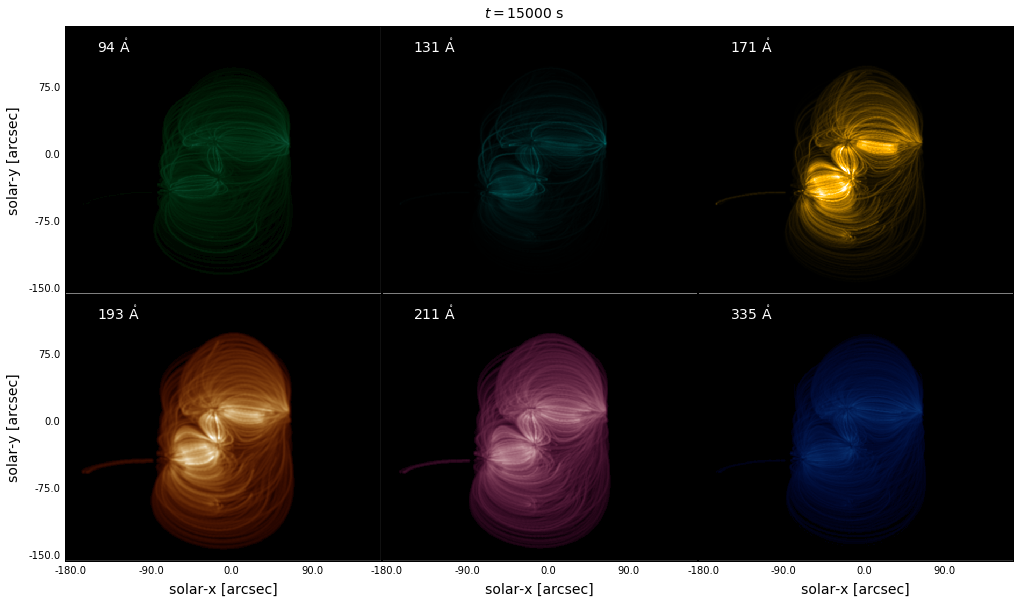

In [18]:
plot_aia_channels(aia_disk_center, 15000 * u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/disk_center/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()),
                  figsize=(17,9))

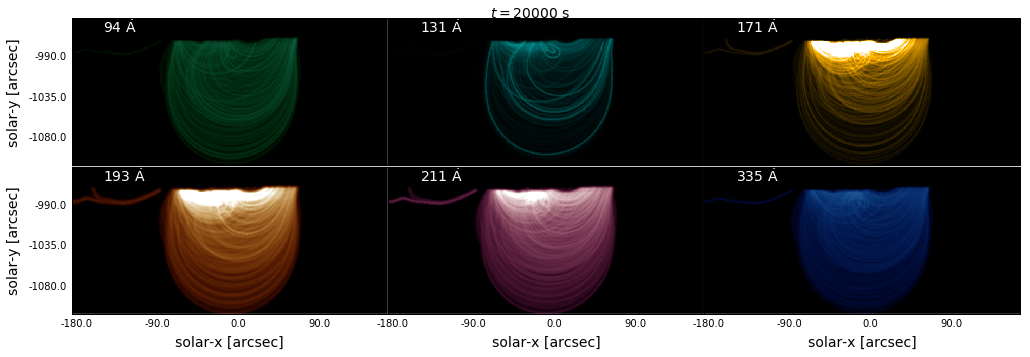

In [27]:
plot_aia_channels(aia_arcade, 20000 * u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/arcade/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()),
                  figsize=(17,5))

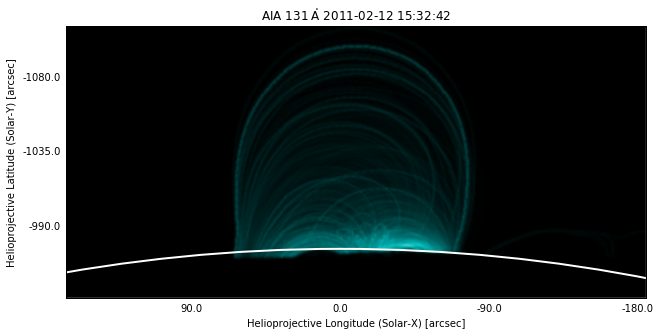

In [43]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/arcade/SDO_AIA/131/map_t000500.fits')
m = m.rotate(180*u.deg)
fig = plt.figure(figsize=(12,5))
ax = fig.gca(projection=m)
m.plot(axes=ax,
       norm=ImageNormalize(vmin=0,vmax=2e2,stretch=SqrtStretch()))
ax.grid(alpha=0)
m.draw_limb(color='w',axes=ax,lw=2);

## Compute Timelags

In [20]:
timelags_off_limb = AIATimeLags(
    aia_off_limb,
    'intensity_maps_intermediate_frequency_off_limb.h5',
    #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/off_limb/'
)

In [21]:
timelags_disk_center = AIATimeLags(
    aia_disk_center,
    'intensity_maps_intermediate_frequency_disk_center.h5',
    #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/disk_center/'
)

In [58]:
timelags_arcade = AIATimeLags(
    aia_arcade,
    'intensity_maps_intermediate_frequency_arcade.h5',
    fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/arcade/'
)

FloatProgress(value=0.0)

In [23]:
timelags_earth = AIATimeLags(aia_earth,
                             'intensity_maps_intermediate_frequency.h5'
                            )

In [59]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

In [60]:
#timelag_maps = {}
for p in channel_pairs:
    #timelag_maps['{}-{}'.format(*p)] = {}
    #timelag_maps['{}-{}'.format(*p)]['off_limb'] = timelags_off_limb.make_timelag_map(f'{p[0]}',f'{p[1]}')
    #timelag_maps['{}-{}'.format(*p)]['disk_center'] = timelags_disk_center.make_timelag_map(f'{p[0]}',f'{p[1]}')
    #timelag_maps['{}-{}'.format(*p)]['earth'] = timelags_earth.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['arcade'] = timelags_arcade.make_timelag_map(f'{p[0]}',f'{p[1]}')

In [61]:
#correlation_maps = {}
for p in channel_pairs:
    #correlation_maps['{}-{}'.format(*p)] = {}
    #correlation_maps['{}-{}'.format(*p)]['off_limb'] = timelags_off_limb.make_correlation_map(f'{p[0]}',f'{p[1]}')
    #correlation_maps['{}-{}'.format(*p)]['disk_center'] = timelags_disk_center.make_correlation_map(f'{p[0]}',f'{p[1]}')
    #correlation_maps['{}-{}'.format(*p)]['earth'] = timelags_earth.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['arcade'] = timelags_arcade.make_correlation_map(f'{p[0]}',f'{p[1]}')

## Compare Results

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


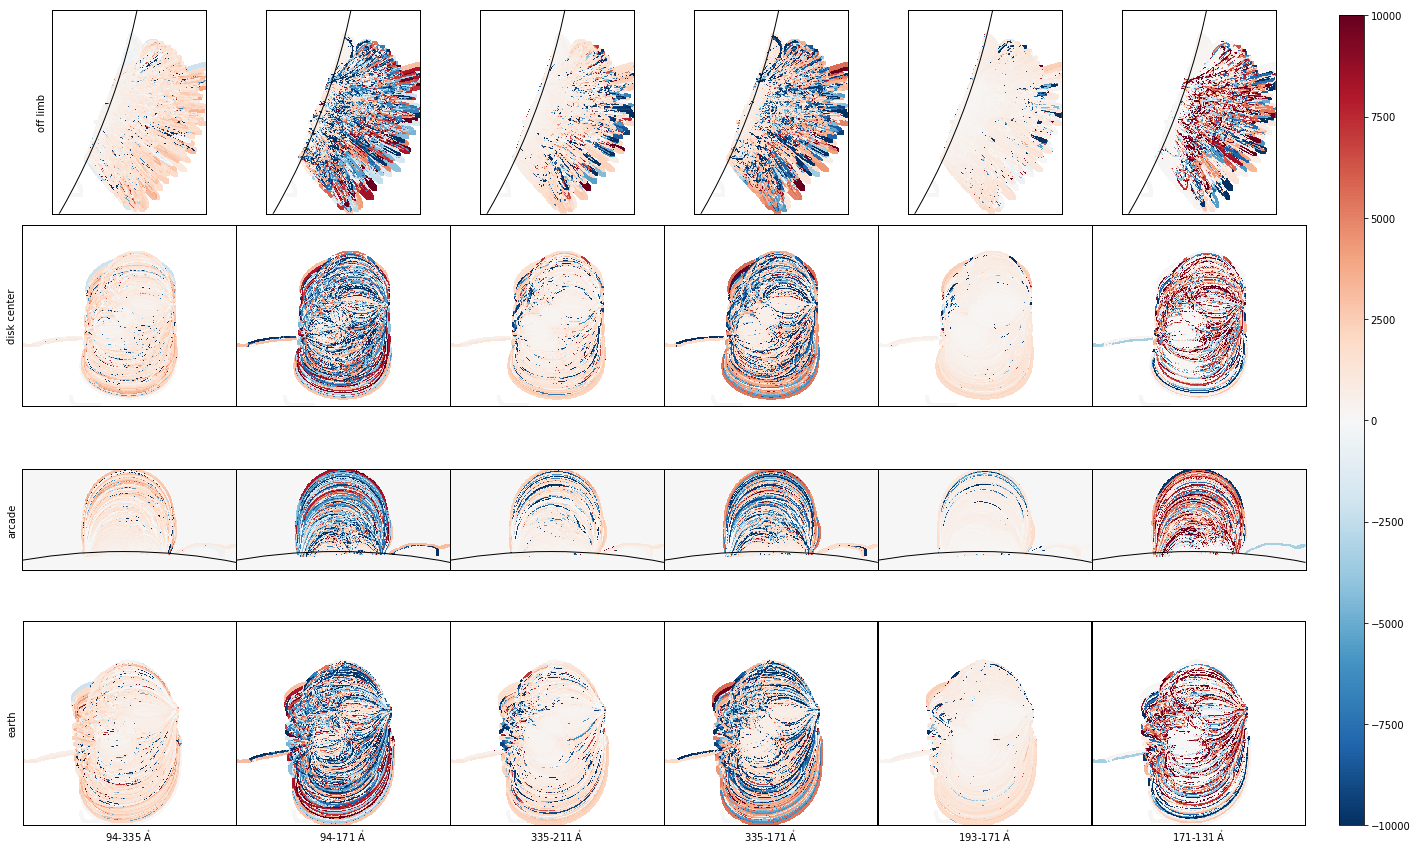

In [62]:
fig = plt.figure(figsize=(23,15))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.125, 0.015, 0.75])
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,los in enumerate(['off_limb', 'disk_center', 'arcade', 'earth']):
        tmp_cor = correlation_maps[f'{c_a}-{c_b}'][los]
        tmp = timelag_maps[f'{c_a}-{c_b}'][los]
        data = np.where(tmp_cor.data / tmp_cor.data.max() < 0.2, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        if j == 2:
            tmp = tmp.rotate(180 * u.deg)
        tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-1e4,'vmax':1e4})
        ax = fig.add_subplot(4,len(channel_pairs),6*j + i + 1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0 or j==2:
            tmp.draw_limb(axes=ax,color='k')
        #tmp.draw_grid(color='k',axes=ax,grid_spacing=10 * u.deg)
        if i == 0:
            lat.set_axislabel(' '.join(los.split('_')))
        #if j < 1:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
        #if i > 0:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
        if j == 3:
            lon.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
cbar = fig.colorbar(im, cax=cax)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


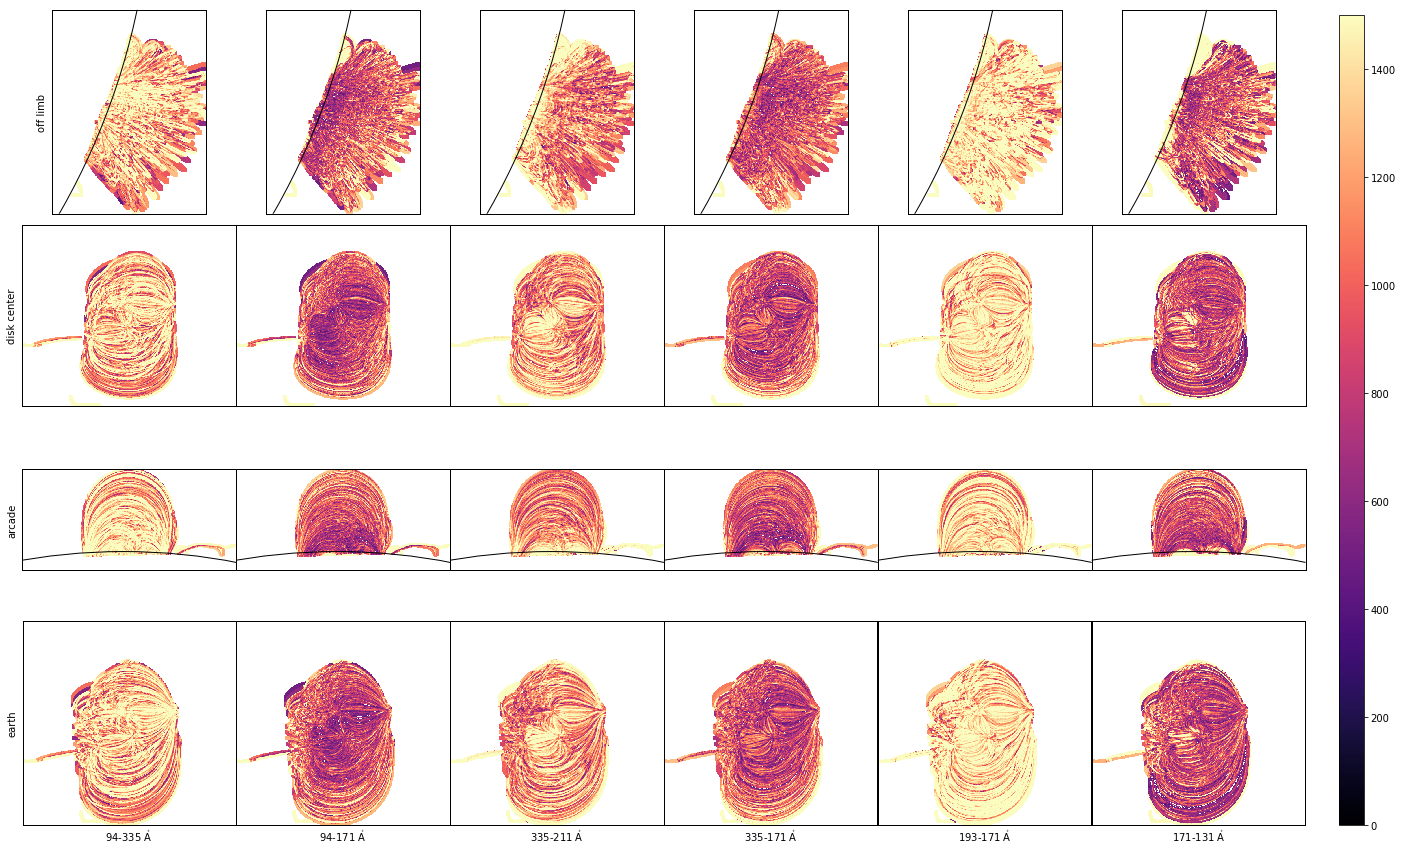

In [94]:
fig = plt.figure(figsize=(23,15))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.125, 0.015, 0.75])
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,los in enumerate(['off_limb', 'disk_center', 'arcade', 'earth']):
        tmp = correlation_maps[f'{c_a}-{c_b}'][los]
        data = np.where(tmp.data / tmp.data.max() < 0.2, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        if j == 2:
            tmp = tmp.rotate(180 * u.deg)
            data = np.where(tmp.data < 1e-1, np.nan, tmp.data)
            tmp = Map(data, tmp.meta)
        tmp.plot_settings.update({'cmap':'magma','vmin':0,'vmax':1.5e3})
        ax = fig.add_subplot(4,len(channel_pairs),6*j + i + 1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0 or j==2:
            tmp.draw_limb(axes=ax,color='k')
        #tmp.draw_grid(color='k',axes=ax,grid_spacing=10 * u.deg)
        if i == 0:
            lat.set_axislabel(' '.join(los.split('_')))
        #if j < 1:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
        #if i > 0:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
        if j == 3:
            lon.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
cbar = fig.colorbar(im, cax=cax)

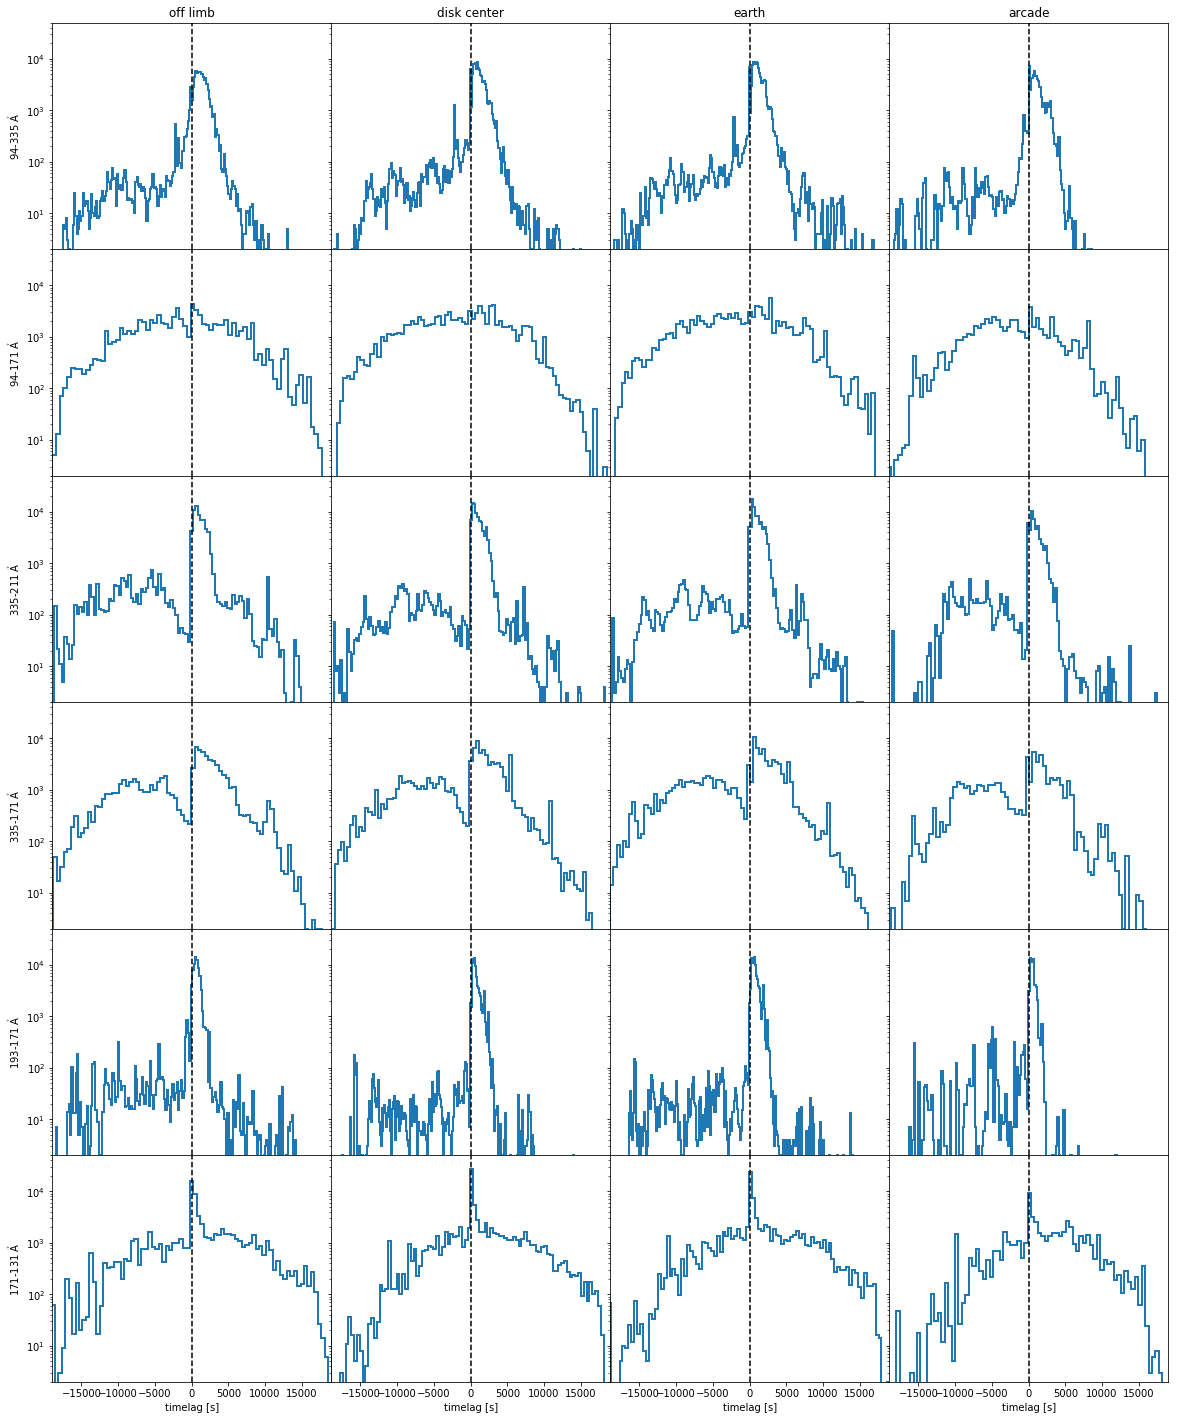

In [81]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(len(channel_pairs),4,figsize=(20,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    for j,los in enumerate(['off_limb','disk_center', 'earth', 'arcade']):
        ax = axes[i,j]
        tmp = timelag_maps['{}-{}'.format(*p)][los]
        data = tmp.data.flatten()
        tmp = correlation_maps['{}-{}'.format(*p)][los]
        data_cor = tmp.data.flatten()
        ax.hist(data[np.where(data_cor / data_cor.max() >= 0.2)], **params,
                label=' '.join(los.split('_')),color=f'C0',ls='-')
        ax.axvline(x=0,ls='--',color='k')
        if j == 0:
            ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
        if i == 5:
            ax.set_xlabel(r'timelag [s]')
        if i == 0:
            ax.set_title(' '.join(los.split('_')))
axes[0,0].set_xlim(-1.9e4,1.9e4);
axes[0,0].set_ylim(2,5e4);
# axes[0,0].set_xscale('symlog',linthreshx=1e1)